In [1]:
!ls $STORE_DIR

Data  Datasets	DL_Projects  Figures  hf  huggingface  Projects  torch_cache


In [2]:
!echo $STORE_DIR/Projects/biggan-pytorch-ecoset/code

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset/code


In [3]:
!ls $STORE_DIR/Projects/biggan-pytorch-ecoset/code

animal_hash.py			inception_tf13.py
BigGANdeep_miniconv.py		inception_utils.py
BigGANdeep_nodist.py		inception_weights_ecoset.pth.tar
BigGANdeep.py			layers.py
BigGANminiconv.py		LICENSE
BigGAN_nodist.py		losses.py
BigGAN.py			make_hdf5.py
calculate_inception_moments.py	prepare_ecoset.sh
datasets.py			__pycache__
E128_imgs.npz			raven.env
E128_inception_moments.npz	README.md
E256_imgs.npz			sample.py
E256_inception_moments_e.npz	sample.sh
E256_inception_moments_i.npz	sync_batchnorm
ecoset_class_counts.pt		test.py
ecoset_class_weights_mean1.pt	TFHub
ecoset_class_weights.pt		train_fns.py
I128_inception_moments.npz	train.py
I256_inception_moments.npz	train.sh
imgs				utils.py


In [4]:
!ls $STORE_DIR/Projects/biggan-pytorch-ecoset/weights


D_best0.pth	   D_optim_copy0.pth  G_ema_best1.pth	 G_optim_copy0.pth
D_best1.pth	   D_optim_copy1.pth  G_ema_best2.pth	 G_optim_copy1.pth
D_best2.pth	   D_optim.pth	      G_ema_best3.pth	 G_optim.pth
D_best3.pth	   D.pth	      G_ema_best4.pth	 G.pth
D_best4.pth	   G_best0.pth	      G_ema_copy0.pth	 state_dict_best0.pth
D_copy0.pth	   G_best1.pth	      G_ema_copy1.pth	 state_dict_best1.pth
D_copy1.pth	   G_best2.pth	      G_ema.pth		 state_dict_best2.pth
D_optim_best0.pth  G_best3.pth	      G_optim_best0.pth  state_dict_best3.pth
D_optim_best1.pth  G_best4.pth	      G_optim_best1.pth  state_dict_best4.pth
D_optim_best2.pth  G_copy0.pth	      G_optim_best2.pth  state_dict_copy0.pth
D_optim_best3.pth  G_copy1.pth	      G_optim_best3.pth  state_dict_copy1.pth
D_optim_best4.pth  G_ema_best0.pth    G_optim_best4.pth  state_dict.pth


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import torch
from torch import nn
import sys
sys.path.append("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset/code")
# from BigGANdeep_nodist import Generator
from BigGAN_nodist import Generator
# /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset/code/BigGANdeep.py
G = Generator()

Adding attention layer in G at resolution 64
Param count for Gs initialized parameters: 33550851


In [3]:
import os
from os.path import join
import torch
from torch import nn
BGEco_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset"
state_dict = torch.load(join(BGEco_root, "weights", "G_ema_best2.pth"))

### Construct the correct config file to load in the weights

In [24]:
# original utils.py failed to load due to missing horovod package, so we port the following code here. 
# import utils
from argparse import ArgumentParser
def prepare_parser():
  usage = 'Parser for all scripts.'
  parser = ArgumentParser(description=usage)

  ### Ecoset Modifications ###
  parser.add_argument(
    '--class_weights_file', type=str, default='ecoset_class_weights.pt')
  parser.add_argument(
    '--use_ecoIS', action='store_true', default = False,
    help='Use IS based on ecoset-trained Inception Net?'
    '(default: %(default)s)')

  ### Dataset/Dataloader stuff ###
  parser.add_argument(
    '--dataset', type=str, default='I128_hdf5',
    help='Which Dataset to train on, out of I128, I256, C10, C100;'
         'Append "_hdf5" to use the hdf5 version for ISLVRC '
         '(default: %(default)s)')
  parser.add_argument(
    '--augment', action='store_true', default=False,
    help='Augment with random crops and flips (default: %(default)s)')
  parser.add_argument(
    '--num_workers', type=int, default=8,
    help='Number of dataloader workers; consider using less for HDF5 '
         '(default: %(default)s)')
  parser.add_argument(
    '--no_pin_memory', action='store_false', dest='pin_memory', default=True,
    help='Pin data into memory through dataloader? (default: %(default)s)')
  parser.add_argument(
    '--shuffle', action='store_true', default=False,
    help='Shuffle the data (strongly recommended)? (default: %(default)s)')
  parser.add_argument(
    '--load_in_mem', action='store_true', default=False,
    help='Load all data into memory? (default: %(default)s)')
  parser.add_argument(
    '--copy_in_mem', action='store_true', default=False,
    help='Copy dataset in /dev/shm/ (default: %(default)s)')
  parser.add_argument(
    '--use_multiepoch_sampler', action='store_true', default=False,
    help='Use the multi-epoch sampler for dataloader? (default: %(default)s)')


  ### Model stuff ###
  parser.add_argument(
    '--model', type=str, default='BigGAN',
    help='Name of the model module (default: %(default)s)')
  parser.add_argument(
    '--G_param', type=str, default='SN',
    help='Parameterization style to use for G, spectral norm (SN) or SVD (SVD)'
          ' or None (default: %(default)s)')
  parser.add_argument(
    '--D_param', type=str, default='SN',
    help='Parameterization style to use for D, spectral norm (SN) or SVD (SVD)'
         ' or None (default: %(default)s)')
  parser.add_argument(
    '--G_ch', type=int, default=64,
    help='Channel multiplier for G (default: %(default)s)')
  parser.add_argument(
    '--D_ch', type=int, default=64,
    help='Channel multiplier for D (default: %(default)s)')
  parser.add_argument(
    '--G_depth', type=int, default=1,
    help='Number of resblocks per stage in G? (default: %(default)s)')
  parser.add_argument(
    '--D_depth', type=int, default=1,
    help='Number of resblocks per stage in D? (default: %(default)s)')
  parser.add_argument(
    '--D_thin', action='store_false', dest='D_wide', default=True,
    help='Use the SN-GAN channel pattern for D? (default: %(default)s)')
  parser.add_argument(
    '--G_shared', action='store_true', default=False,
    help='Use shared embeddings in G? (default: %(default)s)')
  parser.add_argument(
    '--shared_dim', type=int, default=0,
    help='G''s shared embedding dimensionality; if 0, will be equal to dim_z. '
         '(default: %(default)s)')
  parser.add_argument(
    '--dim_z', type=int, default=128,
    help='Noise dimensionality: %(default)s)')
  parser.add_argument(
    '--z_var', type=float, default=1.0,
    help='Noise variance: %(default)s)')
  parser.add_argument(
    '--hier', action='store_true', default=False,
    help='Use hierarchical z in G? (default: %(default)s)')
  parser.add_argument(
    '--cross_replica', action='store_true', default=False,
    help='Cross_replica batchnorm in G?(default: %(default)s)')
  parser.add_argument(
    '--mybn', action='store_true', default=False,
    help='Use my batchnorm (which supports standing stats?) %(default)s)')
  parser.add_argument(
    '--G_nl', type=str, default='relu',
    help='Activation function for G (default: %(default)s)')
  parser.add_argument(
    '--D_nl', type=str, default='relu',
    help='Activation function for D (default: %(default)s)')
  parser.add_argument(
    '--G_attn', type=str, default='64',
    help='What resolutions to use attention on for G (underscore separated) '
         '(default: %(default)s)')
  parser.add_argument(
    '--D_attn', type=str, default='64',
    help='What resolutions to use attention on for D (underscore separated) '
         '(default: %(default)s)')
  parser.add_argument(
    '--norm_style', type=str, default='bn',
    help='Normalizer style for G, one of bn [batchnorm], in [instancenorm], '
         'ln [layernorm], gn [groupnorm] (default: %(default)s)')

  ### Model init stuff ###
  parser.add_argument(
    '--seed', type=int, default=0,
    help='Random seed to use; affects both initialization and '
         ' dataloading. (default: %(default)s)')
  parser.add_argument(
    '--G_init', type=str, default='ortho',
    help='Init style to use for G (default: %(default)s)')
  parser.add_argument(
    '--D_init', type=str, default='ortho',
    help='Init style to use for D(default: %(default)s)')
  parser.add_argument(
    '--skip_init', action='store_true', default=False,
    help='Skip initialization, ideal for testing when ortho init was used '
          '(default: %(default)s)')

  ### Optimizer stuff ###
  parser.add_argument(
    '--G_lr', type=float, default=5e-5,
    help='Learning rate to use for Generator (default: %(default)s)')
  parser.add_argument(
    '--D_lr', type=float, default=2e-4,
    help='Learning rate to use for Discriminator (default: %(default)s)')
  parser.add_argument(
    '--lr_decay', type=float, default=0.0,
    help='Learning rate decay factor (default: %(default)s), no decay if 0')
  parser.add_argument(
    '--G_B1', type=float, default=0.0,
    help='Beta1 to use for Generator (default: %(default)s)')
  parser.add_argument(
    '--D_B1', type=float, default=0.0,
    help='Beta1 to use for Discriminator (default: %(default)s)')
  parser.add_argument(
    '--G_B2', type=float, default=0.999,
    help='Beta2 to use for Generator (default: %(default)s)')
  parser.add_argument(
    '--D_B2', type=float, default=0.999,
    help='Beta2 to use for Discriminator (default: %(default)s)')

  ### Batch size and precision stuff ###
  parser.add_argument(
    '--batch_size', type=int, default=64,
    help='Default overall batchsize (default: %(default)s)')
  parser.add_argument(
    '--G_batch_size', type=int, default=0,
    help='Batch size to use for G; if 0, same as D (default: %(default)s)')
  parser.add_argument(
    '--num_G_accumulations', type=int, default=1,
    help='Number of passes to accumulate G''s gradients over '
         '(default: %(default)s)')
  parser.add_argument(
    '--num_D_steps', type=int, default=2,
    help='Number of D steps per G step (default: %(default)s)')
  parser.add_argument(
    '--num_D_accumulations', type=int, default=1,
    help='Number of passes to accumulate D''s gradients over '
         '(default: %(default)s)')
  parser.add_argument(
    '--split_D', action='store_true', default=False,
    help='Run D twice rather than concatenating inputs? (default: %(default)s)')
  parser.add_argument(
    '--num_epochs', type=int, default=100,
    help='Number of epochs to train for (default: %(default)s)')
  parser.add_argument(
    '--G_fp16', action='store_true', default=False,
    help='Train with half-precision in G? (default: %(default)s)')
  parser.add_argument(
    '--D_fp16', action='store_true', default=False,
    help='Train with half-precision in D? (default: %(default)s)')
  parser.add_argument(
    '--D_mixed_precision', action='store_true', default=False,
    help='Train with half-precision activations but fp32 params in D? '
         '(default: %(default)s)')
  parser.add_argument(
    '--G_mixed_precision', action='store_true', default=False,
    help='Train with half-precision activations but fp32 params in G? '
         '(default: %(default)s)')
  parser.add_argument(
    '--accumulate_stats', action='store_true', default=False,
    help='Accumulate "standing" batchnorm stats? (default: %(default)s)')
  parser.add_argument(
    '--num_standing_accumulations', type=int, default=16,
    help='Number of forward passes to use in accumulating standing stats? '
         '(default: %(default)s)')

  ### Bookkeping stuff ###
  parser.add_argument(
    '--G_eval_mode', action='store_true', default=False,
    help='Run G in eval mode (running/standing stats?) at sample/test time? '
         '(default: %(default)s)')
  parser.add_argument(
    '--save_every', type=int, default=2000,
    help='Save every X iterations (default: %(default)s)')
  parser.add_argument(
    '--num_save_copies', type=int, default=2,
    help='How many copies to save (default: %(default)s)')
  parser.add_argument(
    '--num_best_copies', type=int, default=2,
    help='How many previous best checkpoints to save (default: %(default)s)')
  parser.add_argument(
    '--which_best', type=str, default='IS',
    help='Which metric to use to determine when to save new "best"'
         'checkpoints, one of IS or FID (default: %(default)s)')
  parser.add_argument(
    '--no_fid', action='store_true', default=False,
    help='Calculate IS only, not FID? (default: %(default)s)')
  parser.add_argument(
    '--test_every', type=int, default=5000,
    help='Test every X iterations (default: %(default)s)')
  parser.add_argument(
    '--num_inception_images', type=int, default=50000,
    help='Number of samples to compute inception metrics with '
         '(default: %(default)s)')
  parser.add_argument(
    '--hashname', action='store_true', default=False,
    help='Use a hash of the experiment name instead of the full config '
         '(default: %(default)s)')
  parser.add_argument(
    '--base_root', type=str, default='',
    help='Default location to store all weights, samples, data, and logs '
           ' (default: %(default)s)')
  parser.add_argument(
    '--data_root', type=str, default='data',
    help='Default location where data is stored (default: %(default)s)')
  parser.add_argument(
    '--weights_root', type=str, default='weights',
    help='Default location to store weights (default: %(default)s)')
  parser.add_argument(
    '--logs_root', type=str, default='logs',
    help='Default location to store logs (default: %(default)s)')
  parser.add_argument(
    '--samples_root', type=str, default='samples',
    help='Default location to store samples (default: %(default)s)')
  parser.add_argument(
    '--pbar', type=str, default='mine',
    help='Type of progressbar to use; one of "mine" or "tqdm" '
         '(default: %(default)s)')
  parser.add_argument(
    '--name_suffix', type=str, default='',
    help='Suffix for experiment name for loading weights for sampling '
         '(consider "best0") (default: %(default)s)')
  parser.add_argument(
    '--experiment_name', type=str, default='',
    help='Optionally override the automatic experiment naming with this arg. '
         '(default: %(default)s)')
  parser.add_argument(
    '--load_from', type=str, default='',
    help='Load from a checkpoint from another weights folder. '
         '(default: %(default)s)')
  parser.add_argument(
    '--config_from_name', action='store_true', default=False,
    help='Use a hash of the experiment name instead of the full config '
         '(default: %(default)s)')

  ### EMA Stuff ###
  parser.add_argument(
    '--ema', action='store_true', default=False,
    help='Keep an ema of G''s weights? (default: %(default)s)')
  parser.add_argument(
    '--ema_decay', type=float, default=0.9999,
    help='EMA decay rate (default: %(default)s)')
  parser.add_argument(
    '--use_ema', action='store_true', default=False,
    help='Use the EMA parameters of G for evaluation? (default: %(default)s)')
  parser.add_argument(
    '--ema_start', type=int, default=0,
    help='When to start updating the EMA weights (default: %(default)s)')

  ### Numerical precision and SV stuff ###
  parser.add_argument(
    '--adam_eps', type=float, default=1e-8,
    help='epsilon value to use for Adam (default: %(default)s)')
  parser.add_argument(
    '--BN_eps', type=float, default=1e-5,
    help='epsilon value to use for BatchNorm (default: %(default)s)')
  parser.add_argument(
    '--SN_eps', type=float, default=1e-8,
    help='epsilon value to use for Spectral Norm(default: %(default)s)')
  parser.add_argument(
    '--num_G_SVs', type=int, default=1,
    help='Number of SVs to track in G (default: %(default)s)')
  parser.add_argument(
    '--num_D_SVs', type=int, default=1,
    help='Number of SVs to track in D (default: %(default)s)')
  parser.add_argument(
    '--num_G_SV_itrs', type=int, default=1,
    help='Number of SV itrs in G (default: %(default)s)')
  parser.add_argument(
    '--num_D_SV_itrs', type=int, default=1,
    help='Number of SV itrs in D (default: %(default)s)')

  ### Ortho reg stuff ###
  parser.add_argument(
    '--G_ortho', type=float, default=0.0, # 1e-4 is default for BigGAN
    help='Modified ortho reg coefficient in G(default: %(default)s)')
  parser.add_argument(
    '--D_ortho', type=float, default=0.0,
    help='Modified ortho reg coefficient in D (default: %(default)s)')
  parser.add_argument(
    '--toggle_grads', action='store_true', default=True,
    help='Toggle D and G''s "requires_grad" settings when not training them? '
         ' (default: %(default)s)')

  ### Which train function ###
  parser.add_argument(
    '--which_train_fn', type=str, default='GAN',
    help='How2trainyourbois (default: %(default)s)')

  ### Resume training stuff
  parser.add_argument(
    '--load_weights', type=str, default='',
    help='Suffix for which weights to load (e.g. best0, copy0) '
         '(default: %(default)s)')
  parser.add_argument(
    '--resume', action='store_true', default=False,
    help='Resume training? (default: %(default)s)')

  ### Log stuff ###
  parser.add_argument(
    '--logstyle', type=str, default='%3.3e',
    help='What style to use when logging training metrics?'
         'One of: %#.#f/ %#.#e (float/exp, text),'
         'pickle (python pickle),'
         'npz (numpy zip),'
         'mat (MATLAB .mat file) (default: %(default)s)')
  parser.add_argument(
    '--log_G_spectra', action='store_true', default=False,
    help='Log the top 3 singular values in each SN layer in G? '
         '(default: %(default)s)')
  parser.add_argument(
    '--log_D_spectra', action='store_true', default=False,
    help='Log the top 3 singular values in each SN layer in D? '
         '(default: %(default)s)')
  parser.add_argument(
    '--sv_log_interval', type=int, default=10,
    help='Iteration interval for logging singular values '
         ' (default: %(default)s)')

  return parser

# Arguments for sample.py; not presently used in train.py
def add_sample_parser(parser):
  parser.add_argument(
    '--sample_npz', action='store_true', default=False,
    help='Sample "sample_num_npz" images and save to npz? '
         '(default: %(default)s)')
  parser.add_argument(
    '--sample_num_npz', type=int, default=50000,
    help='Number of images to sample when sampling NPZs '
         '(default: %(default)s)')
  parser.add_argument(
    '--sample_sheets', action='store_true', default=False,
    help='Produce class-conditional sample sheets and stick them in '
         'the samples root? (default: %(default)s)')
  parser.add_argument(
    '--sample_interps', action='store_true', default=False,
    help='Produce interpolation sheets and stick them in '
         'the samples root? (default: %(default)s)')
  parser.add_argument(
    '--sample_sheet_folder_num', type=int, default=-1,
    help='Number to use for the folder for these sample sheets '
         '(default: %(default)s)')
  parser.add_argument(
    '--sample_random', action='store_true', default=False,
    help='Produce a single random sheet? (default: %(default)s)')
  parser.add_argument(
    '--sample_trunc_curves', type=str, default='',
    help='Get inception metrics with a range of variances?'
         'To use this, specify a startpoint, step, and endpoint, e.g. '
         '--sample_trunc_curves 0.2_0.1_1.0 for a startpoint of 0.2, '
         'endpoint of 1.0, and stepsize of 1.0.  Note that this is '
         'not exactly identical to using tf.truncated_normal, but should '
         'have approximately the same effect. (default: %(default)s)')
  parser.add_argument(
    '--sample_inception_metrics', action='store_true', default=False,
    help='Calculate Inception metrics with sample.py? (default: %(default)s)')
  return parser


def update_config_roots(config):
  if config['base_root']:
    print('Pegging all root folders to base root %s' % config['base_root'])
    for key in ['data', 'weights', 'logs', 'samples']:
      config['%s_root' % key] = '%s/%s' % (config['base_root'], key)
  return config

In [26]:
import torch.nn as nn
imsize_dict = {'I32': 32, 'I32_hdf5': 32,
               'I64': 64, 'I64_hdf5': 64,
               'I128': 128, 'I128_hdf5': 128,
               'I256': 256, 'I256_hdf5': 256,
               'C10': 32, 'C100': 32,
               'E128': 128, 'E128_hdf5': 128,
               'E256': 256, 'E256_hdf5': 256,
               'small_E256_hdf5': 256}
root_dict = {'I32': 'ImageNet', 'I32_hdf5': 'ILSVRC32.hdf5',
             'I64': 'ImageNet', 'I64_hdf5': 'ILSVRC64.hdf5',
             'I128': 'ImageNet', 'I128_hdf5': 'ILSVRC128.hdf5',
             'I256': 'ImageNet', 'I256_hdf5': 'ILSVRC256.hdf5',
             'C10': 'cifar', 'C100': 'cifar',
             'E128': 'E128', 'E128_hdf5': 'E128.hdf5',
             'E256': 'ecoset', 'E256_hdf5': 'E256.hdf5',
             'small_E256_hdf5': 'small_E256.hdf5'}
nclass_dict = {'I32': 1000, 'I32_hdf5': 1000,
               'I64': 1000, 'I64_hdf5': 1000,
               'I128': 1000, 'I128_hdf5': 1000,
               'I256': 1000, 'I256_hdf5': 1000,
               'C10': 10, 'C100': 100,
               'E128': 565, 'E128_hdf5': 565,
               'E256': 565, 'E256_hdf5': 565,
               'small_E256_hdf5': 565}
# Number of classes to put per sample sheet
classes_per_sheet_dict = {'I32': 50, 'I32_hdf5': 50,
                          'I64': 50, 'I64_hdf5': 50,
                          'I128': 20, 'I128_hdf5': 20,
                          'I256': 20, 'I256_hdf5': 20,
                          'C10': 10, 'C100': 100,
                          'E128': 20, 'E128_hdf5': 20,
                          'E256': 20, 'E256_hdf5': 20,
                          'small_E256_hdf5': 20}
activation_dict = {'inplace_relu': nn.ReLU(inplace=True),
                   'relu': nn.ReLU(inplace=False),
                   'ir': nn.ReLU(inplace=True)}

In [33]:
args = [
    "--data_root", "$DATA_ROOT",
    "--weights_root", "$WEIGHTS_ROOT", 
    "--logs_root", "$LOGS_ROOT",
    "--samples_root", "$SAMPLE_ROOT",
    "--model", "BigGAN",
    "--class_weights_file", "ecoset_class_weights_mean1.pt",
    "--num_epochs", "900",
    "--dataset", "E256_hdf5",
    "--shuffle", "--num_workers", "0", "--batch_size", "44",
    "--num_G_accumulations", "1", "--num_D_accumulations", "1",
    "--num_D_steps", "2", "--G_lr", "5.0e-05", "--D_lr", "3.0e-04", "--D_B2", "0.999", "--G_B2", "0.999",
    "--G_attn", "64", "--D_attn", "64",
    "--G_nl", "inplace_relu", "--D_nl", "inplace_relu",
    "--SN_eps", "1e-6", "--BN_eps", "1e-5", "--adam_eps", "1e-6",
    "--G_ortho", "0.0",
    "--G_shared",
    "--G_init", "ortho", "--D_init", "ortho",
    "--dim_z", "140", "--shared_dim", "128", "--hier",
    "--G_eval_mode",
    "--G_ch", "96", "--D_ch", "96",
    "--ema", "--use_ema", "--ema_start", "20000",
    "--test_every", "1", "--save_every", "9000",
    "--num_best_copies", "5", "--num_save_copies", "2", "--num_inception_images", "50000",
    "--copy_in_mem", "--resume", "--experiment_name", "check_mem_sample",
    "--load_from", "${LOAD_FROM}", "--load_weights", "best2", "--augment",
    "--sample_inception_metrics", "--sample_trunc_curves", "0.1_0.1_2.0", "--z_var", "0.7"
]
parser = prepare_parser()
parser = add_sample_parser(parser)
config = vars(parser.parse_args(args))

In [15]:
config

{'class_weights_file': 'ecoset_class_weights_mean1.pt',
 'use_ecoIS': False,
 'dataset': 'E256_hdf5',
 'augment': True,
 'num_workers': 0,
 'pin_memory': True,
 'shuffle': True,
 'load_in_mem': False,
 'copy_in_mem': True,
 'use_multiepoch_sampler': False,
 'model': 'BigGAN',
 'G_param': 'SN',
 'D_param': 'SN',
 'G_ch': 96,
 'D_ch': 96,
 'G_depth': 1,
 'D_depth': 1,
 'D_wide': True,
 'G_shared': True,
 'shared_dim': 128,
 'dim_z': 140,
 'z_var': 0.7,
 'hier': True,
 'cross_replica': False,
 'mybn': False,
 'G_nl': 'inplace_relu',
 'D_nl': 'inplace_relu',
 'G_attn': '64',
 'D_attn': '64',
 'norm_style': 'bn',
 'seed': 0,
 'G_init': 'ortho',
 'D_init': 'ortho',
 'skip_init': False,
 'G_lr': 5e-05,
 'D_lr': 0.0003,
 'lr_decay': 0.0,
 'G_B1': 0.0,
 'D_B1': 0.0,
 'G_B2': 0.999,
 'D_B2': 0.999,
 'batch_size': 44,
 'G_batch_size': 0,
 'num_G_accumulations': 1,
 'num_D_steps': 2,
 'num_D_accumulations': 1,
 'split_D': False,
 'num_epochs': 900,
 'G_fp16': False,
 'D_fp16': False,
 'D_mixed_pre

In [16]:
from torch import nn
# config = dict(G_ch=64, dim_z=128, bottom_width=4, resolution=128,
#                G_kernel_size=3, G_attn='64', n_classes=1000,
#                num_G_SVs=1, num_G_SV_itrs=1,
#                G_shared=True, shared_dim=0, hier=False,
#                cross_replica=False, mybn=False,
#                G_activation=nn.ReLU(inplace=False),
#                G_lr=5e-5, G_B1=0.0, G_B2=0.999, adam_eps=1e-8,
#                BN_eps=1e-5, SN_eps=1e-12, G_mixed_precision=False, G_fp16=False,
#                G_init='ortho', skip_init=False, no_optim=False,
#                G_param='SN', norm_style='bn')
G = Generator(**config)

Adding attention layer in G at resolution 64
Param count for Gs initialized parameters: 70551875


In [34]:
BGEco_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset"
# config = torch.load(join(BGEco_root, "weights", "state_dict_best2.pth"))
# config['dataset'] = 'E256_hdf5'
config['resolution'] = imsize_dict[config['dataset']]
config['n_classes'] = nclass_dict[config['dataset']]
config['G_activation'] = activation_dict[config['G_nl']]
config['D_activation'] = activation_dict[config['D_nl']]
config = update_config_roots(config)
config['skip_init'] = True
config['no_optim'] = True
G = Generator(**config)

Adding attention layer in G at resolution 64


In [35]:
G

Generator(
  (activation): ReLU(inplace=True)
  (shared): Embedding(565, 128)
  (linear): SNLinear(in_features=20, out_features=24576, bias=True)
  (blocks): ModuleList(
    (0): ModuleList(
      (0): GBlock(
        (activation): ReLU(inplace=True)
        (conv1): SNConv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): SNConv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_sc): SNConv2d(1536, 1536, kernel_size=(1, 1), stride=(1, 1))
        (bn1): ccbn(
          out: 1536, in: 148, cross_replica=False
          (gain): SNLinear(in_features=148, out_features=1536, bias=False)
          (bias): SNLinear(in_features=148, out_features=1536, bias=False)
        )
        (bn2): ccbn(
          out: 1536, in: 148, cross_replica=False
          (gain): SNLinear(in_features=148, out_features=1536, bias=False)
          (bias): SNLinear(in_features=148, out_features=1536, bias=False)
        )
      )
    )
    (1): ModuleList(

In [20]:
config

{'itr': 152000,
 'epoch': 389,
 'save_num': 1,
 'save_best_num': 2,
 'best_IS': 48.289593,
 'best_FID': 39.94306983919067,
 'config': {'class_weights_file': 'ecoset_class_weights_mean1.pt',
  'dataset': 'ecoset_cs500',
  'augment': False,
  'num_workers': 0,
  'pin_memory': True,
  'shuffle': True,
  'load_in_mem': False,
  'copy_in_mem': True,
  'use_multiepoch_sampler': False,
  'model': 'BigGAN',
  'G_param': 'SN',
  'D_param': 'SN',
  'G_ch': 96,
  'D_ch': 96,
  'G_depth': 1,
  'D_depth': 1,
  'D_wide': True,
  'G_shared': True,
  'shared_dim': 128,
  'dim_z': 140,
  'z_var': 1.0,
  'hier': True,
  'cross_replica': False,
  'mybn': False,
  'G_nl': 'inplace_relu',
  'D_nl': 'inplace_relu',
  'G_attn': '64',
  'D_attn': '64',
  'norm_style': 'bn',
  'seed': 0,
  'G_init': 'ortho',
  'D_init': 'ortho',
  'skip_init': False,
  'G_lr': 5e-05,
  'D_lr': 0.0003,
  'G_B1': 0.0,
  'D_B1': 0.0,
  'G_B2': 0.999,
  'D_B2': 0.999,
  'batch_size': 1760,
  'G_batch_size': 0,
  'num_G_accumulatio

In [69]:
BGEco_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset"
state_dict = torch.load(join(BGEco_root, "weights", "G_best4.pth"))# _ema
G.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [124]:
suffix = "best2"
config = torch.load(join(BGEco_root, "weights", f"state_dict_{suffix}.pth"))['config']
weights_dict = torch.load(join(BGEco_root, "weights", f"G_{suffix}.pth"))
G = Generator(**config)
G.load_state_dict(weights_dict, strict=True)
G.to("cuda").eval()
G.requires_grad_(False);

Adding attention layer in G at resolution 64
Param count for Gs initialized parameters: 82179971


### GAN loading script

In [11]:
suffix = "best2"
config = torch.load(join(BGEco_root, "weights", f"state_dict_{suffix}.pth"))['config']
weights_dict = torch.load(join(BGEco_root, "weights", f"G_{suffix}.pth"))
G = Generator(**config)
G.load_state_dict(weights_dict, strict=True)
G.to("cuda").eval()
G.requires_grad_(False);

Adding attention layer in G at resolution 64
Param count for Gs initialized parameters: 82179971


### Generate sample for visualization

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid, save_image

In [13]:
device = "cuda"
G.to(device).eval()
G.requires_grad_(False);

In [16]:
from torch.utils.data import DataLoader, WeightedRandomSampler
class Distribution(torch.Tensor):
  # Init the params of the distribution
  def init_distribution(self, dist_type, **kwargs):
    # cwd = os.getcwd()
    filepath = os.path.join("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset/code", 'ecoset_class_counts.pt')
    class_weights = torch.load(filepath).tolist()
    self.dist_type = dist_type
    self.dist_kwargs = kwargs
    if self.dist_type == 'normal':
      self.mean, self.var = kwargs['mean'], kwargs['var']
    elif self.dist_type == 'categorical':
      self.num_categories = kwargs['num_categories']
      self.sampler = WeightedRandomSampler(class_weights, len(self), replacement=True)

  def sample_(self):
    if self.dist_type == 'normal':
      self.normal_(self.mean, self.var)
    elif self.dist_type == 'categorical':
      self.random_(0, self.num_categories)
      self[:] = torch.tensor(list(self.sampler), dtype=torch.int)
    # return self.variable

  # Silly hack: overwrite the to() method to wrap the new object
  # in a distribution as well
  def to(self, *args, **kwargs):
    new_obj = Distribution(self)
    new_obj.init_distribution(self.dist_type, **self.dist_kwargs)
    new_obj.data = super().to(*args, **kwargs)
    return new_obj


def prepare_z_y(G_batch_size, dim_z, nclasses, device='cuda',
                fp16=False,z_var=1.0):
  z_ = Distribution(torch.randn(G_batch_size, dim_z, requires_grad=False))
  z_.init_distribution('normal', mean=0, var=z_var)
  z_ = z_.to(device,torch.float16 if fp16 else torch.float32)

  if fp16:
    z_ = z_.half()

  y_ = Distribution(torch.zeros(G_batch_size, requires_grad=False))
  y_.init_distribution('categorical',num_categories=nclasses)
  y_ = y_.to(device, torch.int64)
  return z_, y_

In [142]:
y_

Distribution([120, 342,  58, 219, 336, 447,  25, 173, 163, 228,  81, 278, 140,
                4, 347, 178, 156, 294, 393, 114, 394, 305, 505, 248, 399],
             device='cuda:0')

In [145]:
config['z_var']

1.0

In [14]:
# use the same process as in the sample.py
batch_size = 25
z_, y_ = prepare_z_y(batch_size, G.dim_z, config['n_classes'],
                    device=device, fp16=config['G_fp16'], 
                    z_var=config['z_var'])
z_.sample_()
y_.sample_()
with torch.no_grad():
    imgs = G.forward(z_, G.shared(y_)).cpu()

grid = make_grid((imgs + 1) / 2, nrow=5)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

NameError: name 'prepare_z_y' is not defined

In [108]:
torch.allclose(imgs[0], imgs[1], atol=1e-2, rtol=1e-1)

False

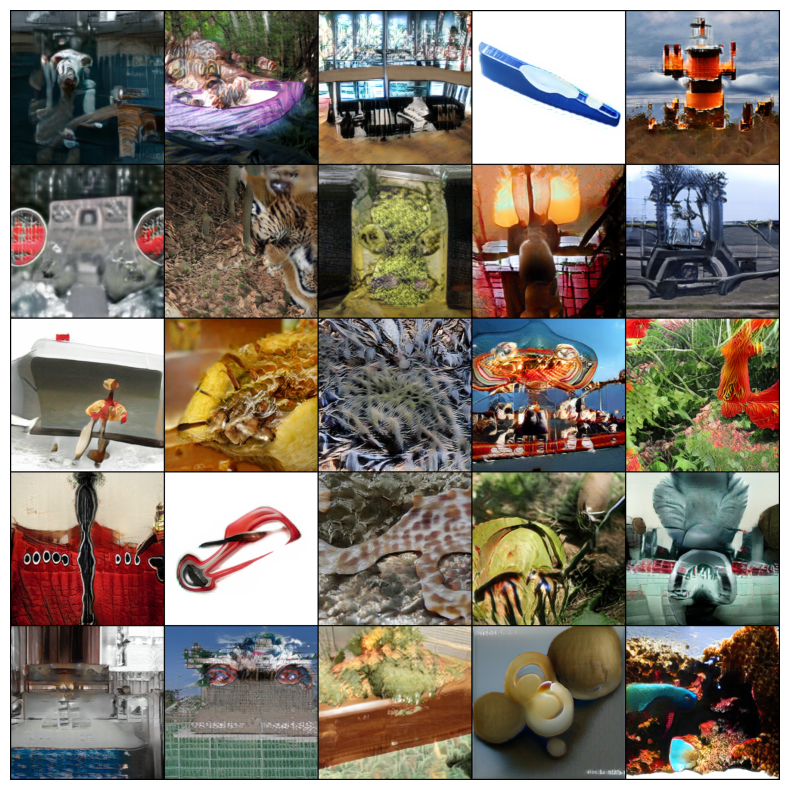

In [15]:
# custom sampling, seems equivalent
batch_size = 25
zs = torch.randn(batch_size, 140).to(device)
ys = torch.randint(0, 565, (batch_size,), dtype=torch.long, device=device)
with torch.no_grad():
    imgs = G.forward(zs, G.shared(ys)).cpu()

grid = make_grid((imgs + 1) / 2, nrow=5)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

### Norm of weights ~ step size

In [155]:
G.shared.weight.shape

torch.Size([565, 128])

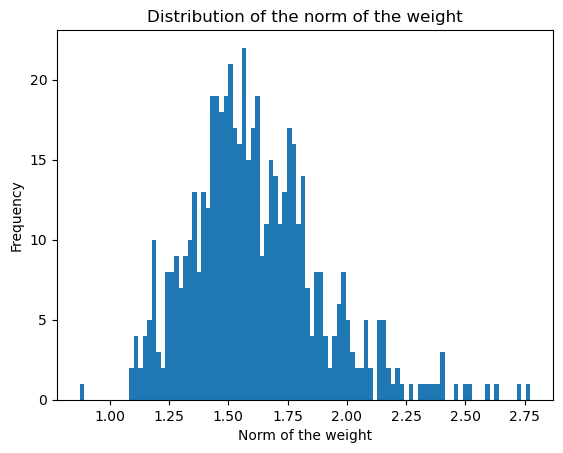

In [156]:
# plot the dist. of norm of the weight
plt.hist(G.shared.weight.norm(dim=1).cpu().numpy(), bins=100)
plt.xlabel('Norm of the weight')
plt.ylabel('Frequency')
plt.title('Distribution of the norm of the weight')
plt.show()

### Script

In [ ]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm.auto import tqdm, trange
import sys
sys.path.append("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset/code")
# from BigGANdeep_nodist import Generator
from BigGAN_nodist import Generator


class Distribution(torch.Tensor):
  # Init the params of the distribution
  def init_distribution(self, dist_type, **kwargs):
    # cwd = os.getcwd()
    filepath = os.path.join("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset/code", 'ecoset_class_counts.pt')
    class_weights = torch.load(filepath).tolist()
    self.dist_type = dist_type
    self.dist_kwargs = kwargs
    if self.dist_type == 'normal':
      self.mean, self.var = kwargs['mean'], kwargs['var']
    elif self.dist_type == 'categorical':
      self.num_categories = kwargs['num_categories']
      self.sampler = WeightedRandomSampler(class_weights, len(self), replacement=True)

  def sample_(self):
    if self.dist_type == 'normal':
      self.normal_(self.mean, self.var)
    elif self.dist_type == 'categorical':
      self.random_(0, self.num_categories)
      self[:] = torch.tensor(list(self.sampler), dtype=torch.int)
    # return self.variable

  # Silly hack: overwrite the to() method to wrap the new object
  # in a distribution as well
  def to(self, *args, **kwargs):
    new_obj = Distribution(self)
    new_obj.init_distribution(self.dist_type, **self.dist_kwargs)
    new_obj.data = super().to(*args, **kwargs)
    return new_obj


def prepare_z_y(G_batch_size, dim_z, nclasses, device='cuda',
                fp16=False,z_var=1.0):
  z_ = Distribution(torch.randn(G_batch_size, dim_z, requires_grad=False))
  z_.init_distribution('normal', mean=0, var=z_var)
  z_ = z_.to(device,torch.float16 if fp16 else torch.float32)

  if fp16:
    z_ = z_.half()

  y_ = Distribution(torch.zeros(G_batch_size, requires_grad=False))
  y_.init_distribution('categorical',num_categories=nclasses)
  y_ = y_.to(device, torch.int64)
  return z_, y_

from collections import defaultdict
suffix = "best2"
batch_size = 100
BGEco_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset"

device = "cuda"
config = torch.load(join(BGEco_root, "weights", f"state_dict_{suffix}.pth"))['config']
weights_dict = torch.load(join(BGEco_root, "weights", f"G_{suffix}.pth"))
G = Generator(**config)
G.load_state_dict(weights_dict, strict=True)
G.to(device).eval()
G.requires_grad_(False);

batch_num = 50000 // batch_size
global_cnt = 0
from collections import defaultdict

# Initialize counter - defaultdict(int) automatically starts at 0 for new keys
class_counters = defaultdict(int)

for batch_idx in trange(batch_num):
    z_, y_ = prepare_z_y(batch_size, G.dim_z, config['n_classes'],
                        device=device, fp16=config['G_fp16'], 
                        z_var=config['z_var'])
    z_.sample_()
    y_.sample_()
    with torch.no_grad():
        imgs = G.forward(z_, G.shared(y_)).cpu()

    imgs = torch.tensor((imgs + 1) / 2)  # denormalize
    # save the images one by one
    for i in range(batch_size):
        cls_idx = int(y_[i])
        save_image(imgs[i], join(BGEco_root, "samples_50k", 
                 f"img_cls{cls_idx:03d}_{class_counters[cls_idx]:05d}.jpg"))
        class_counters[cls_idx] += 1
        global_cnt += 1

if False:
    grid = make_grid(imgs, nrow=5)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

### Detect images

In [4]:
BGEco_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset"
imgdir = join(BGEco_root, "samples_50k", )

In [8]:
# Import required libraries for YOLO
from ultralytics import YOLO
import glob
from tqdm.auto import tqdm
import os
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from os.path import join
import pickle

BGEco_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset"
imgdir = join(BGEco_root, "samples_50k", )
# Load the YOLO model and move to GPU
model = YOLO('yolov8n.pt')  # Load YOLOv8 nano model
model.to('cuda')  # Move model to GPU

# Get all jpg images in the directory
image_files = sorted(glob.glob(os.path.join(imgdir, "*.jpg")))

# Dictionary to store dog images
dog_images = {}
results_all = []
# Set batch size
batch_size = 128

# Process images in batches
for i in tqdm(range(0, len(image_files), batch_size), desc="Detecting dogs"):
    batch_files = image_files[i:i + batch_size]
    
    # Run inference on batch
    results = model(batch_files, device='cuda')
    results_all.extend(results)
    # Process results for each image in batch
    for img_path, result in zip(batch_files, results):
        boxes = result.boxes
        for box in boxes:
            if box.cls == 16:  # If dog detected
                confidence = box.conf.item()
                dog_images[img_path] = box #confidence
                break

print(f"Found {len(dog_images)} images containing dogs")
pickle.dump(results_all, open(join(BGEco_root, "samples_50k_results_all.pkl"), "wb"))
pickle.dump(dog_images, open(join(BGEco_root, "samples_50k_dog_images.pkl"), "wb"))


# Sort dog images by confidence score
sorted_dog_images = dict(sorted(dog_images.items(), key=lambda x: x[1], reverse=True))

# Display some example detections
plt.figure(figsize=(15, 10))
for i, (img_path, conf) in enumerate(list(sorted_dog_images.items())[:4]):
    plt.subplot(2, 2, i+1)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'Confidence: {conf:.2f}')
    plt.axis('off')
plt.tight_layout()
plt.show()


Detecting dogs:   0%|          | 0/391 [00:00<?, ?it/s]


0: 640x640 2 vases, 5.6ms
1: 640x640 1 parking meter, 5.6ms
2: 640x640 (no detections), 5.6ms
3: 640x640 (no detections), 5.6ms
4: 640x640 (no detections), 5.6ms
5: 640x640 1 cat, 5.6ms
6: 640x640 1 sandwich, 1 cake, 5.6ms
7: 640x640 (no detections), 5.6ms
8: 640x640 1 bed, 5.6ms
9: 640x640 1 bird, 1 baseball bat, 5.6ms
10: 640x640 (no detections), 5.6ms
11: 640x640 1 person, 5.6ms
12: 640x640 (no detections), 5.6ms
13: 640x640 (no detections), 5.6ms
14: 640x640 (no detections), 5.6ms
15: 640x640 1 airplane, 5.6ms
16: 640x640 (no detections), 5.6ms
17: 640x640 1 person, 5.6ms
18: 640x640 (no detections), 5.6ms
19: 640x640 (no detections), 5.6ms
20: 640x640 (no detections), 5.6ms
21: 640x640 (no detections), 5.6ms
22: 640x640 (no detections), 5.6ms
23: 640x640 (no detections), 5.6ms
24: 640x640 (no detections), 5.6ms
25: 640x640 1 cat, 5.6ms
26: 640x640 (no detections), 5.6ms
27: 640x640 (no detections), 5.6ms
28: 640x640 1 person, 5.6ms
29: 640x640 1 parking meter, 5.6ms
30: 640x640 (

KeyboardInterrupt: 

In [18]:
for img_path, result in zip(batch_files, results):
    boxes = result.boxes
    for box in boxes:
        if box.cls == 16:  # If dog detected
            confidence = box.conf.item()
            # dog_images[img_path] = confidence
            print(confidence, box)
            break

0.37718260288238525 ultralytics.engine.results.Boxes object with attributes:

cls: tensor([16.], device='cuda:0')
conf: tensor([0.3772], device='cuda:0')
data: tensor([[  0.7570,   0.6326, 163.9219, 251.7585,   0.3772,  16.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (256, 256)
shape: torch.Size([1, 6])
xywh: tensor([[ 82.3394, 126.1955, 163.1649, 251.1259]], device='cuda:0')
xywhn: tensor([[0.3216, 0.4930, 0.6374, 0.9810]], device='cuda:0')
xyxy: tensor([[  0.7570,   0.6326, 163.9219, 251.7585]], device='cuda:0')
xyxyn: tensor([[0.0030, 0.0025, 0.6403, 0.9834]], device='cuda:0')


In [ ]:
# Import required libraries for YOLO
from ultralytics import YOLO
import glob
from tqdm.auto import tqdm
import os
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from os.path import join
import pickle

dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/GAN_sample_fid"
imgdir = join(dataset_root, "BigGAN_trunc07", )
# Load the YOLO model and move to GPU
model = YOLO('yolov8n.pt')  # Load YOLOv8 nano model
model.to('cuda')  # Move model to GPU

# Get all jpg images in the directory
image_files = sorted(glob.glob(os.path.join(imgdir, "*.png")))

# Dictionary to store dog images
dog_images = {}
results_all = []
# Set batch size
batch_size = 128

# Process images in batches
for i in tqdm(range(0, len(image_files), batch_size), desc="Detecting dogs"):
    batch_files = image_files[i:i + batch_size]
    
    # Run inference on batch
    results = model(batch_files, device='cuda')
    results_all.extend(results)
    # Process results for each image in batch
    for img_path, result in zip(batch_files, results):
        boxes = result.boxes
        for box in boxes:
            if box.cls == 16:  # If dog detected
                confidence = box.conf.item()
                dog_images[img_path] = box #confidence
                break

print(f"Found {len(dog_images)} images containing dogs")
pickle.dump(results_all, open(join(dataset_root, "BigGAN_trunc07_results_all.pkl"), "wb"))
pickle.dump(dog_images, open(join(dataset_root, "BigGAN_trunc07_dog_images.pkl"), "wb"))



In [15]:
results[1]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',

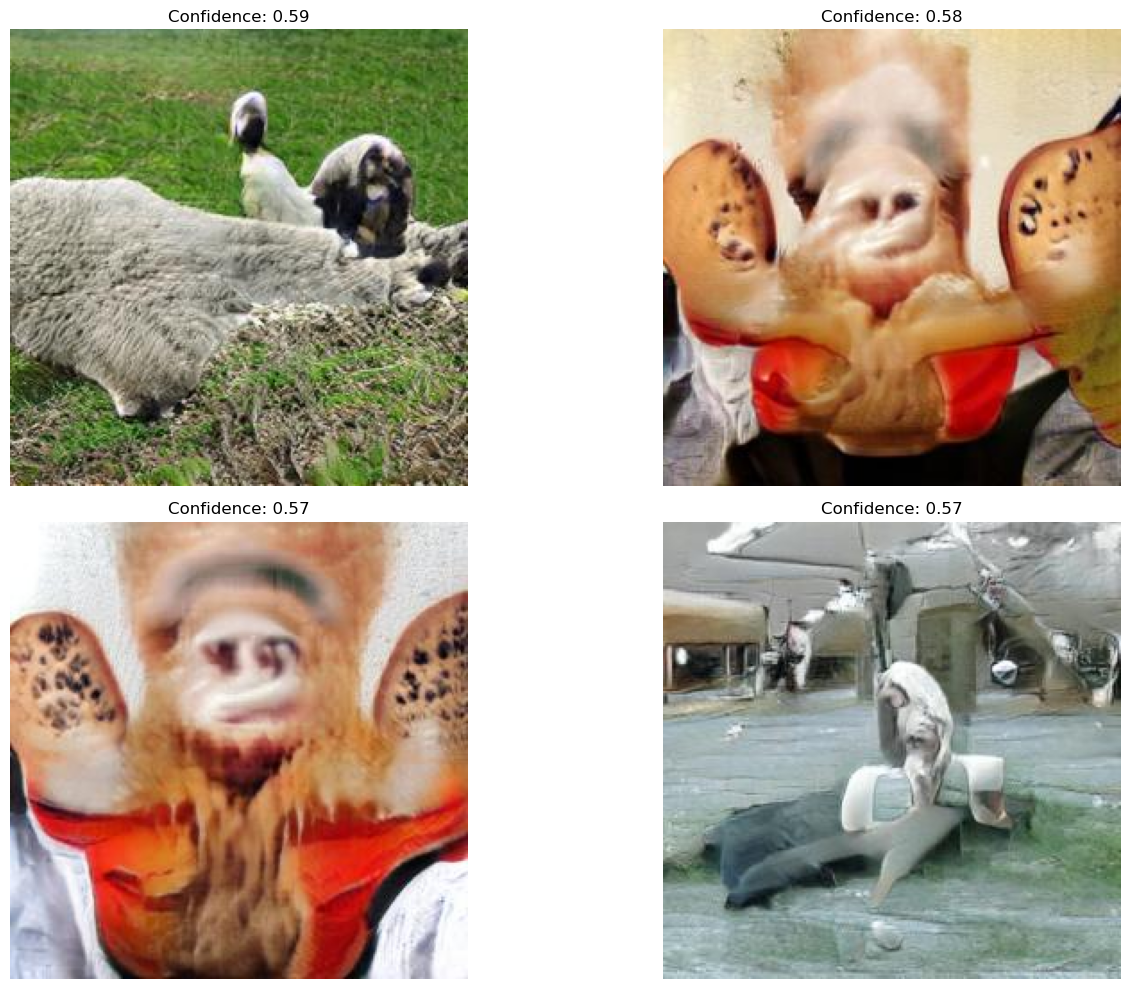

In [11]:
import matplotlib.pyplot as plt
# Sort dog images by confidence score
sorted_dog_images = dict(sorted(dog_images.items(), key=lambda x: x[1], reverse=True))

# Display some example detections
plt.figure(figsize=(15, 10))
for i, (img_path, conf) in enumerate(list(sorted_dog_images.items())[10:14]
                                     ):
    plt.subplot(2, 2, i+1)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'Confidence: {conf:.2f}')
    plt.axis('off')
plt.tight_layout()
plt.show()